# Zillow Time Series Analysis

## Business Understanding

#isolated according to descriptive statistics the top 10 zips for each group 

## Data Understanding

## EDA & Cleaning

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns',300)
pd.set_option('display.max_info_columns',300)
pd.set_option('display.max_rows', 300)

df = pd.read_csv('https://raw.githubusercontent.com/learn-co-curriculum/dsc-phase-4-project/main/time-series/zillow_data.csv')
df.to_csv('zillow_data.csv', index=False)

In [80]:
# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [2]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [3]:
print(df.shape)
print('Unique Region IDs are {}'.format(df['RegionID'].nunique()))
print('Unique Region Names are {}'.format(df['RegionName'].nunique()))
print('Unique Cities are {}'.format(df['City'].nunique()))
print('Unique Metro Areas are {}.'.format(df['Metro'].nunique()))
print('Unique States are {}'.format(df['State'].nunique()))

(14723, 272)
Unique Region IDs are 14723
Unique Region Names are 14723
Unique Cities are 7554
Unique Metro Areas are 701.
Unique States are 51


There seem to be no duplicate entries, though understandably there are fewer unique cities than zip codes ("region names"), as larger cities especially encompass multiple zip codes.

We can also tell from the column names that the dataset includes the median prices of homes from April 1996 to April 2018. 

In [4]:
df['Metro'].value_counts()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
                                 ... 
Houghton                            1
Lamesa                              1
Fort Madison                        1
Vernal                              1
Kingsville                          1
Name: Metro, Length: 701, dtype: int64

In [5]:
df['City'].value_counts()

New York          114
Los Angeles        95
Houston            88
San Antonio        48
Washington         45
                 ... 
Talala              1
Garden Prairie      1
Goodspring          1
Suncook             1
Lower               1
Name: City, Length: 7554, dtype: int64

The top-represented metro areas are New York, Los Angeles metro area, and Chicago. The top-represented cities are New York, Los Angeles, and Houston. 

The only identifier column with a null value is "Metro." The other null values are found in the date columns. 

In [6]:
# Replace nulls in dataframe with row average 
m = df.mean(axis=1)
for i,col in enumerate(df): 
    df.iloc[:,i] = df.iloc[:,i].fillna(m)

Next, I need to determine the geographic regions and/or cities I'm going to focus on for my analysis. To do this, I'm going to use a rough estimate of return on investment (ROI), which, just for this purpose, will simply be value of the property on the most recent "time of holding" in the data (April 2018), measured against the "cost" of the property on an artifically selected purchase date. 

I went with June 2009 as my "purchase date," as this was declared the end of the recession by the [National Bureau of Economic Research](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008). The 2008 financial crisis and subsequent recession had a devastating effect on the real estate market, and I didn't want this extraordinary event to have an outsize effect on the areas I chose for my analysis. 

In [7]:
#Create a new column that shows the return on investment on a property 
#held in April 2018 if purchased in April 2015. 
df['roi'] = (((df['2018-04']-df['2009-06'])/df['2009-06'])*100).round(2)

In [8]:
top_rois = df.sort_values(by=['roi'],ascending=False)

In [9]:
#Creating new dataframe with just the ROIs that show a positive return on investment
rois_over_100 = df[df['roi']>100]

In [10]:
rois_over_100['State'].value_counts()

CA    160
CO     26
FL     19
MA     12
NY      8
WA      7
TN      5
PA      4
MI      2
ND      2
OK      1
GA      1
TX      1
AZ      1
AL      1
NJ      1
SC      1
DC      1
Name: State, dtype: int64

In [11]:
pops = pd.read_csv("population_by_zip_2010.csv") 
pops.shape

(1622831, 6)

In [12]:
pops['zipcode'].nunique()

33119

In [13]:
pops = pops.drop(['minimum_age','maximum_age','gender','geo_id'], axis=1)

In [14]:
pops.head()

,population,zipcode
0,50,61747
1,5,64120
2,1389,95117
3,231,74074
4,56,58042


In [15]:
pops.shape

(1622831, 2)

In [16]:
#Have to aggregate 
zip_groups = pops.groupby([ "zipcode"]).sum().reset_index()
zip_groups.shape

(33119, 2)

In [17]:
# Merge zipcodes/population df with real estate df 
merge = zip_groups.merge(df, how='inner', left_on = 'zipcode', right_on='RegionName')
merge.shape

(14707, 275)

In [18]:
merge.head()

,zipcode,population,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
0,1001,50307,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,112300.0,112100.0,111900.0,111800.0,111700.0,111700.0,111900.0,112100.0,112300.0,112500.0,112800.0,113000.0,113300.0,113600.0,113900.0,114200.0,114500.0,114800.0,115200.0,115600.0,115900.0,116200.0,116400.0,116600.0,116700.0,116800.0,116900.0,117100.0,117300.0,117500.0,117800.0,118300.0,118700.0,119100.0,119500.0,120000.0,120400.0,120900.0,121300.0,121700.0,122100.0,122600.0,123100.0,123800.0,124400.0,124900.0,125400.0,125900.0,126400.0,127000.0,127500.0,128100.0,128800.0,129400.0,130200.0,131100.0,131900.0,132700.0,133400.0,134100.0,134800.0,135400.0,136100.0,136800.0,137500.0,138400.0,139400.0,140600.0,141800.0,143000.0,144200.0,145400.0,146800.0,148200.0,149500.0,150900.0,152600.0,154500.0,155900.0,156800.0,157700.0,158700.0,159900.0,161100.0,162200.0,163300.0,164300.0,165500.0,166800.0,168100.0,169300.0,170600.0,172000.0,173600.0,175300.0,177200.0,179200.0,181300.0,183500.0,185700.0,187600.0,189500.0,191600.0,193900.0,196400.0,199300.0,202300.0,205500.0,208600.0,211500.0,214200.0,216800.0,219000.0,220500.0,221600.0,222200.0,222500.0,222600.0,222400.0,222100.0,221600.0,221100.0,220700.0,220600.0,220600.0,220700.0,221100.0,221600.0,222000.0,222200.0,221900.0,221300.0,220300.0,219200.0,218100.0,217100.0,216200.0,215200.0,213900.0,212400.0,210800.0,209100.0,207800.0,206800.0,205900.0,205100.0,204300.0,203700.0,203200.0,202500.0,201700.0,201000.0,200300.0,199500.0,198800.0,197900.0,197200.0,197100.0,197500.0,198100.0,198600.0,198300.0,197900.0,197800.0,198300.0,199100.0,199700.0,199500.0,198900.0,197500.0,195900.0,193500.0,190900.0,189600.0,190100.0,190200.0,189700.0,188900.0,188100.0,187600.0,187900.0,188500.0,188300.0,187500.0,187500.0,187800.0,187200.0,186200.0,185800.0,185300.0,184

In [19]:
#Drop unnecessary identifier columns 
joined = merge.drop(['RegionID','RegionName'], axis=1)
joined.head()

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
0,1001,50307,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,112300.0,112100.0,111900.0,111800.0,111700.0,111700.0,111900.0,112100.0,112300.0,112500.0,112800.0,113000.0,113300.0,113600.0,113900.0,114200.0,114500.0,114800.0,115200.0,115600.0,115900.0,116200.0,116400.0,116600.0,116700.0,116800.0,116900.0,117100.0,117300.0,117500.0,117800.0,118300.0,118700.0,119100.0,119500.0,120000.0,120400.0,120900.0,121300.0,121700.0,122100.0,122600.0,123100.0,123800.0,124400.0,124900.0,125400.0,125900.0,126400.0,127000.0,127500.0,128100.0,128800.0,129400.0,130200.0,131100.0,131900.0,132700.0,133400.0,134100.0,134800.0,135400.0,136100.0,136800.0,137500.0,138400.0,139400.0,140600.0,141800.0,143000.0,144200.0,145400.0,146800.0,148200.0,149500.0,150900.0,152600.0,154500.0,155900.0,156800.0,157700.0,158700.0,159900.0,161100.0,162200.0,163300.0,164300.0,165500.0,166800.0,168100.0,169300.0,170600.0,172000.0,173600.0,175300.0,177200.0,179200.0,181300.0,183500.0,185700.0,187600.0,189500.0,191600.0,193900.0,196400.0,199300.0,202300.0,205500.0,208600.0,211500.0,214200.0,216800.0,219000.0,220500.0,221600.0,222200.0,222500.0,222600.0,222400.0,222100.0,221600.0,221100.0,220700.0,220600.0,220600.0,220700.0,221100.0,221600.0,222000.0,222200.0,221900.0,221300.0,220300.0,219200.0,218100.0,217100.0,216200.0,215200.0,213900.0,212400.0,210800.0,209100.0,207800.0,206800.0,205900.0,205100.0,204300.0,203700.0,203200.0,202500.0,201700.0,201000.0,200300.0,199500.0,198800.0,197900.0,197200.0,197100.0,197500.0,198100.0,198600.0,198300.0,197900.0,197800.0,198300.0,199100.0,199700.0,199500.0,198900.0,197500.0,195900.0,193500.0,190900.0,189600.0,190100.0,190200.0,189700.0,188900.0,188100.0,187600.0,187900.0,188500.0,188300.0,187500.0,187500.0,187800.0,187200.0,186200.0,185800.0,185300.0,184000.0,182400.0,181200.0,180400.

I went back-and-forth quite a bit on what how to distinguish "urban" vs "rural" in my dataset. At first I was going to use the Urban-Rural Commuting Areas [source here](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes.aspx#.U9lO7GPDWHo) put out by the U.S. Department of Agriculture, but as these rely heavily on commuting, differences in population are not as stark. Yet, I wanted something with a little more granularity than the U.S Census Bureau's designation of [urbanized areas](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html) (>50,000 people) and [urban clusters](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html)(between 2,500 and 49,999 people). I want to make sure my model is able to distinguish a city like Los Angeles from a city like Charlotte, for example. 

I took some inspiration from how the [National Center on Education Statistics](https://nces.ed.gov/programs/edge/docs/locale_classifications.pdf) classifies large-, medium-, and small-size cities. Though these classifications rely heavily on location data (particularly to distinguish urban vs. suburban), which I'm not going to mess with, it gave me the idea to designate zip codes in terms of density. 
- very dense (100,000+). In this case, the most populous zip code in my datset is 60629, in Chicago, with a population of 341,748.  
- dense (25,000 - 99,999). Allows us to isolate some zipcodes in some nicely mid-size cities like Naples, FL; Jacksonville, FL;  and Portland, OR. 
- not dense (fewer than 25,000). 

This method is imperfect, as it does not take location into account, and zip codes are not a uniform size. However, I think this will allow me to accomplish my primary purpose of isolating real estate trends for big-name cities vs. smaller cities and towns. 

In [20]:
vdense = joined.loc[joined['population']>=100000]
vdense.sort_values(by='population',ascending=True).head()

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
1582,11231,100008,New York,NY,New York,New York,1996,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,969500.0,940900.0,912300.0,887300.0,869900.0,862700.0,867700.0,884600.0,911100.0,943300.0,979600.0,1016900.0,1050700.0,1080900.0,1109000.0,1132100.0,1148200.0,1160200.0,1170900.0,1182700.0,1196200.0,1209600.0,1223500.0,1236900.0,1247200.0,1255800.0,1266000.0,1277100.0,1287600.0,1297700.0,1307900.0,1319800.0,1333100.0,1345100.0,1357000.0,1371600.0,1387600.0,1406900.0,1430100.0,1451100.0,1463900.0,1468500.0,1466900.0,1463800.0,1460800.0,1455000.0,1449300.0,1449000.0,1453200.0,1462600.0,1473500.0,1476700.0,1468700.0,1452800.0,1432700.0,1415800.0,1403400.

In [21]:
dense = joined.loc[(joined['population']>= 25000) & (joined['population']<= 99999)]
dense.sort_values(by=['population'],ascending =False)

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
4569,29209,99972,Columbia,SC,Columbia,Richland,2016,70300.000000,70300.000000,70300.000000,70400.000000,70500.000000,70700.000000,71000.000000,71400.000000,72000.000000,72700.000000,73500.000000,74300.000000,75300.000000,76300.000000,77400.000000,78600.000000,79800.000000,81000.000000,82300.000000,83600.000000,85000.000000,86400.000000,87700.000000,89000.000000,90300.000000,91500.000000,92500.000000,93400.000000,94000.000000,94400.000000,94500.000000,94400.000000,94200.000000,93800.000000,93500.000000,93100.000000,92600.000000,92300.000000,91900.000000,91800.000000,91700.000000,91800.000000,92000.000000,92300.000000,92800.000000,93400.000000,94200.000000,95100.000000,96100.000000,97100.000000,98000.000000,99000.000000,99800.000000,100600.000000,101100.000000,101500.000000,101700.000000,101700.000000,101600.000000,101500.000000,101200.000000,100900.000000,100600.000000,100500.000000,100500.000000,100600.000000,100800.000000,101200.000000,101800.000000,102400.000000,103000.000000,103600.000000,104200.000000,104700.000000,105200.000000,105700.000000,106000.000000,106300.000000,106500.000000,106600.000000,106700.000000,106700.000000,106900.000000,107200.000000,107600.000000,107800.000000,108100.000000,108400.000000,108700.000000,109100.000000,109700.000000,110200.000000,110600.000000,110800.000000,110900.000000,110900.000000,111100.000000,111300.000000,111500.000000,111700.000000,111800.000000,112000.000000,112300.000000,112800.000000,113600.000000,114600.000000,115600.000000,116600.000000,117700.000000,118700.000000,119800.000000,120900.000000,121900.000000,122800.000000,123500.000000,124100.000000,124700.000000,125200.0,125600.0,126000.0,126400.0,126700.0,127000.0,127300.0,127600.0,127800.0,128000.0,128200.0,128300.0,128400.0,128600.0,128900.0,129300.0,129500.0,129700.0,129900.0,130000.0,13

In [22]:
not_dense = joined.loc[(joined['population']<= 24999)]
not_dense.sort_values(by=['population'],ascending=False)

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
4554,29127,24999,Prosperity,SC,Newberry,Newberry,8108,72000.000000,72200.000000,72300.000000,72500.000000,72700.000000,72800.000000,72900.000000,73000.000000,73200.000000,73500.000000,73800.000000,74000.000000,74300.000000,74600.000000,74900.000000,75300.000000,75800.000000,76300.000000,76900.000000,77700.000000,78600.000000,79700.000000,80800.000000,82000.000000,83400.000000,84800.000000,86400.000000,88000.000000,89600.000000,91100.000000,92600.000000,94100.000000,95700.000000,97200.000000,98700.000000,100000.000000,101300.000000,102500.000000,103800.000000,105000.000000,106000.000000,107000.000000,107900.000000,108800.000000,109800.000000,110900.000000,111900.000000,112800.000000,113600.000000,114400.000000,115100.000000,115800.000000,116300.000000,116700.000000,117000.000000,117400.000000,117900.000000,118400.000000,119000.000000,119500.000000,120000.000000,120500.000000,120900.000000,121200.000000,121300.000000,121200.000000,120900.000000,120600.000000,120300.000000,120100.000000,120000.000000,119800.000000,119500.000000,119300.000000,119200.000000,119100.000000,118900.000000,118600.000000,118100.000000,117800.000000,117800.000000,118200.000000,118800.000000,119500.000000,120400.000000,121200.000000,122100.000000,123100.000000,124200.000000,125200.000000,126100.000000,127100.000000,128300.000000,129800.000000,131400.000000,133000.000000,134500.000000,136300.000000,138300.000000,140500.000000,142900.000000,145100.000000,147100.000000,148700.000000,149800.000000,150600.000000,151000.000000,151200.000000,151400.000000,151300.000000,150600.000000,149700.000000,149400.000000,150700.000000,153500.000000,156500.000000,158600.000000,159900.000000,160700.000000,161400.000000,162300.000000,163100.000000,163800.000000,164200.000000,164400.000000,1.642000e+05,1.638000e+05,1.632000e+05,1.626000e+0

In [23]:
not_dense.shape

(5824, 273)

In [24]:
#Reshape all 3 dataframes from wide to long format 
#Function to melt dataframe with the datetime columns
#Set date column as index for dataset
def melt(df):
    melted = pd.melt(
        df, 
        id_vars = ['zipcode','population','City','State','Metro','CountyName','SizeRank','roi'], 
        var_name = ['time']) 
    return melted

In [25]:
vdense = melt(vdense)

In [26]:
vdense['time'] = pd.to_datetime(vdense['time'])

In [27]:
vdense = vdense.set_index('time')

In [28]:
dense = melt(dense)

In [29]:
dense['time'] = pd.to_datetime(dense['time'])

In [30]:
dense = dense.set_index('time')

In [31]:
not_dense = melt(not_dense)

In [32]:
not_dense['time'] = pd.to_datetime(not_dense['time'])

In [33]:
not_dense = not_dense.set_index('time')

In [34]:
#Function to change certain columns from int64 to string
def to_string(df): 
    df['zipcode'] = df['zipcode'].astype(str)
    df['SizeRank'] = df['SizeRank'].astype(str)
    df['population'] = df['population'].astype(str)
    df['roi'] = df['roi'].astype(str)
    return df

In [35]:
vdense = to_string(vdense)
dense = to_string(dense)
not_dense = to_string(not_dense)

In [36]:
#Now to figure out which zipcodes to focus on 
not_dense_roi = not_dense.drop_duplicates(subset=['zipcode']).roi

In [37]:
#plt.hist(not_dense_roi.to_numpy())

In [38]:
dense_roi = dense.drop_duplicates(subset=['zipcode']).roi

In [39]:
#plt.hist(dense_roi.to_numpy())

In [40]:
vdense_roi = vdense.drop_duplicates(subset=['zipcode']).roi

In [41]:
#plt.hist(vdense_roi.to_numpy())

In [42]:
not_dense_zips = not_dense.drop_duplicates(subset='zipcode').sort_values(by=['roi'],ascending=False).iloc[:10].zipcode.to_list()

In [43]:
dense_zips = dense.drop_duplicates(subset='zipcode').sort_values(by=['roi'],ascending=False).iloc[:10].zipcode.to_list()

In [44]:
vdense_zips = vdense.drop_duplicates(subset='zipcode').sort_values(by=['roi'],ascending=False).iloc[:10].zipcode.to_list()

In [45]:
print(not_dense_zips)
print(dense_zips)
print(vdense_zips)

['2111', '80543', '74740', '80651', '4411', '94028', '11975', '94038', '27980', '80102']
['48034', '98008', '92586', '94618', '33140', '90008', '92583', '33181', '94402', '48220']
['92571', '94066', '91950', '11106', '94014', '33162', '95380', '98105', '33055', '33135']


In [46]:
nd_top10 = not_dense[not_dense['zipcode'].isin(not_dense_zips)]

In [47]:
dense_top10 = dense[dense['zipcode'].isin(dense_zips)]

In [48]:
vd_top10 = vdense[vdense['zipcode'].isin(vdense_zips)]

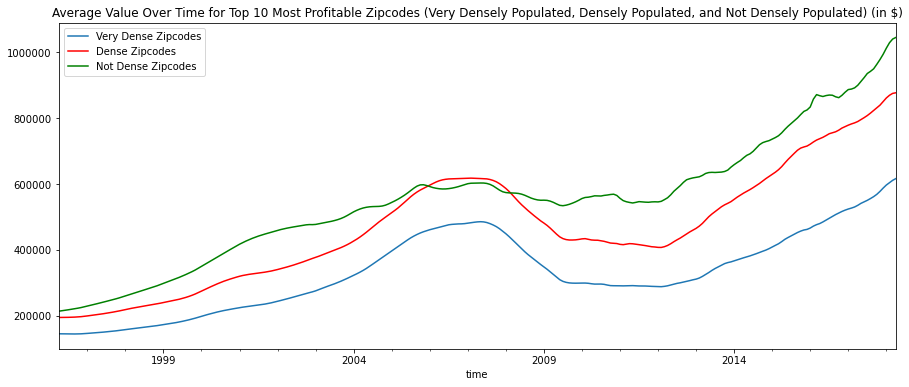

In [49]:
fig1 = plt.figure(figsize=(15,6))
ax1 = fig1.add_subplot()

vd_top10.groupby(pd.Grouper(freq='M')).mean()['value'].plot(label = 'Very Dense Zipcodes')
dense_top10.groupby(pd.Grouper(freq='M')).mean()['value'].plot(c='r',label='Dense Zipcodes')
nd_top10.groupby(pd.Grouper(freq='M')).mean()['value'].plot(c='g', label='Not Dense Zipcodes')

ax1.ticklabel_format(axis='y', style='plain')

plt.title(label='Average Value Over Time for Top 10 Most Profitable Zipcodes (Very Densely Populated, Densely Populated, and Not Densely Populated) (in $)')

plt.legend();
#ax1.plot(vd_top10.index, vd_top10['value'])
#ax1.plot(dense_top10['value'])

The above graph represents the average value over time for each of the three categories of zipcodes. This visualization offers some insights (surprisingly, the value of the three categories over time is the inverse of what I expected, with "not dense"/rural zipcodes being the most expensive, and "very dense" zipcodes being the least expensive. 


However, this graph, being cumulative does not communicate specific information about our target, ROI. To figure gain more information about ROI, we'll convert the dataframes one last time to make the "ROI" column an integer, and convert the "Value" column to string (since we're done with that for now).

Furthermore, I can see here that the data is not stationary and follows a general upward trend. We can use `differencing` as one strategy to try and get rid of some of that trend. Next, I'll calculate how the value of homes in each zipcode have changed month-to-month. From there, I will use the value "difference" to create a new "ROI" column, and then be able to plot the moving and rolling averages for each zip code. 

In [50]:
# Doing some datatype conversions for top 10 dataframes
# Since ROI was converted to a string for the visualization above, I want to convert back to integer
vd_top10['roi'] = pd.to_numeric(vd_top10['roi'])
dense_top10['roi'] = pd.to_numeric(dense_top10['roi'])
nd_top10['roi'] = pd.to_numeric(nd_top10['roi'])

<ipython-input-50-c3f5da7d86f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vd_top10['roi'] = pd.to_numeric(vd_top10['roi'])
<ipython-input-50-c3f5da7d86f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dense_top10['roi'] = pd.to_numeric(dense_top10['roi'])
<ipython-input-50-c3f5da7d86f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [51]:
# As of right now the "ROI" column displays the AVERAGE
# ROI for that zip code from the time period 2009-2018. I now want ROI to reflect month-to-month
# changes in ROI for that particular zipcode. I need to calculate the ROI from month to month. 

# Will rename current 'roi' column as 'average roi' before I calculate above
vd_top10 = vd_top10.rename(columns={'roi':'avg_roi'})
dense_top10 = dense_top10.rename(columns={'roi':'avg_roi'})
nd_top10 = nd_top10.rename(columns={'roi':'avg_roi'})

### Checking Variance

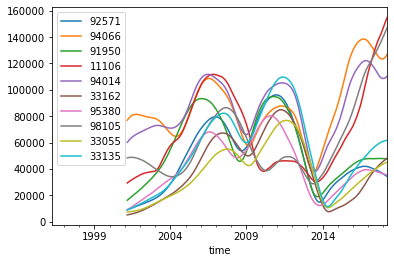

In [52]:
# Using the very dense zip codes as an example
for x in vdense_zips:
    frame = vdense[vdense.zipcode==x]
    frame.assign(vol=frame.value.rolling(window=60).std()).vol.plot(label=x) 
plt.legend()

#vdense[vdense.zipcode==x]

#Select different window sizes and see when zips start to pool 
#Experiment with clustering? Hierarchical/Gaussian clustering in sklearn to find zips that are clustered according
#To their variance 

#If you have clusters of variance you can theoretically develop a model for each time series

I can see from the variance graph that there are two main clusters of zip codes with similar standard deviations. Home values of 11106, 94066, 98105, and 98105 are farther from the mean, while the remaining zip codes contain values that are closer to the mean.  

## Improving Stationarity

### Differencing Values for Each Zipcode 
I now need to drill down to focusing on individual zipcodes, as opposed to categories of zipcodes, so that I can communicate actionable, valuable information to our investor. 

I want to know how the month-to-month ROI in order to draw conclusions about the zipcodes that would be most beneficial to act on. I'm also hoping that this will help get rid of some upward trend that I saw in my data. 

In [53]:
# For each of the 3 categories of zipcodes (very dense, dense, not dense)
# group by zipcode and isolate the 'Value' column. Calculate the difference
# in price from month to month. 
vd_top10['difference'] = vd_top10.groupby(['zipcode'])['value'].diff()
vd_top10 = vd_top10.dropna()

In [54]:
dense_top10['difference'] = dense_top10.groupby(['zipcode'])['value'].diff()
dense_top10 = dense_top10.dropna()

In [55]:
nd_top10['difference'] = nd_top10.groupby(['zipcode'])['value'].diff().round(3)
nd_top10 = nd_top10.dropna()

In [56]:
#Now create new "ROI" column that uses the difference column to calculate return on investment
vd_top10['roi'] = (vd_top10['difference']/vd_top10['value'])*10000
vd_top10['roi'] = vd_top10['roi'].round(2)

In [57]:
dense_top10['roi'] = (dense_top10['difference']/dense_top10['value'])*10000
dense_top10['roi'] = dense_top10['roi'].round(2)

In [58]:
nd_top10['roi'] = (nd_top10['difference']/nd_top10['value'])*10000
nd_top10['roi'] = nd_top10['roi'].round(2)

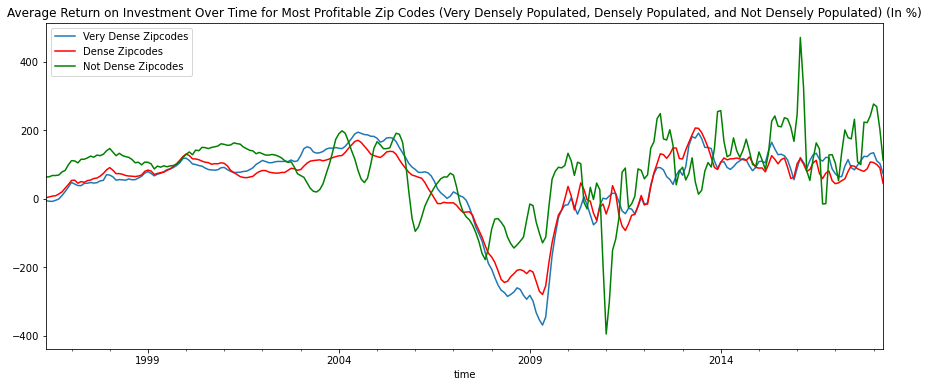

In [59]:
fig1 = plt.figure(figsize=(15,6))
ax1 = fig1.add_subplot()

vd_top10.groupby(pd.Grouper(freq='M')).mean()['roi'].plot(label = 'Very Dense Zipcodes')
dense_top10.groupby(pd.Grouper(freq='M')).mean()['roi'].plot(c='r',label='Dense Zipcodes')
nd_top10.groupby(pd.Grouper(freq='M')).mean()['roi'].plot(c='g', label='Not Dense Zipcodes')

ax1.ticklabel_format(axis='y', style='plain')

plt.title(label='Average Return on Investment Over Time for Most Profitable Zip Codes (Very Densely Populated, Densely Populated, and Not Densely Populated) (In %)')
plt.legend();

Interestingly, the ROIs over time for all three categories of zipcodes seem to be pretty close together. ROIs for very densely populated and densely populated zipcodes seem to move together, including when investments for both groups took a hit of similar magnitude in 2008-2009. However, returns for the not dense zipcodes did not decline as much (though they took a pretty sharp dip for some reason in 2011 before zooming back up). Could not-dense areas represent a safer real estate investment? 

The `differencing` technique also helped remove some of the upward trend in my dataset. The data is now moving along a general horizantal line, though there is some evidence of seasonality, as the returns for not-dense zipcodes especially seem to be peaking at regular intervals. I can get more specific at assesisng the stationarity through plotting the moving average for each zipcode:

In [60]:
#Create a function to plot moving averages for each zipcode in the 
#3 categories 
def plot_moving_average(df):
    axes = df.reset_index().pivot(index='time',
    columns = 'zipcode',
    values = 'roi').plot(
        subplots=True,
        figsize=(10,40)); 
    zips = df.zipcode.unique()
    for idx in range(len(zips)): 
        axes[idx].legend(fontsize=15, loc='upper left')

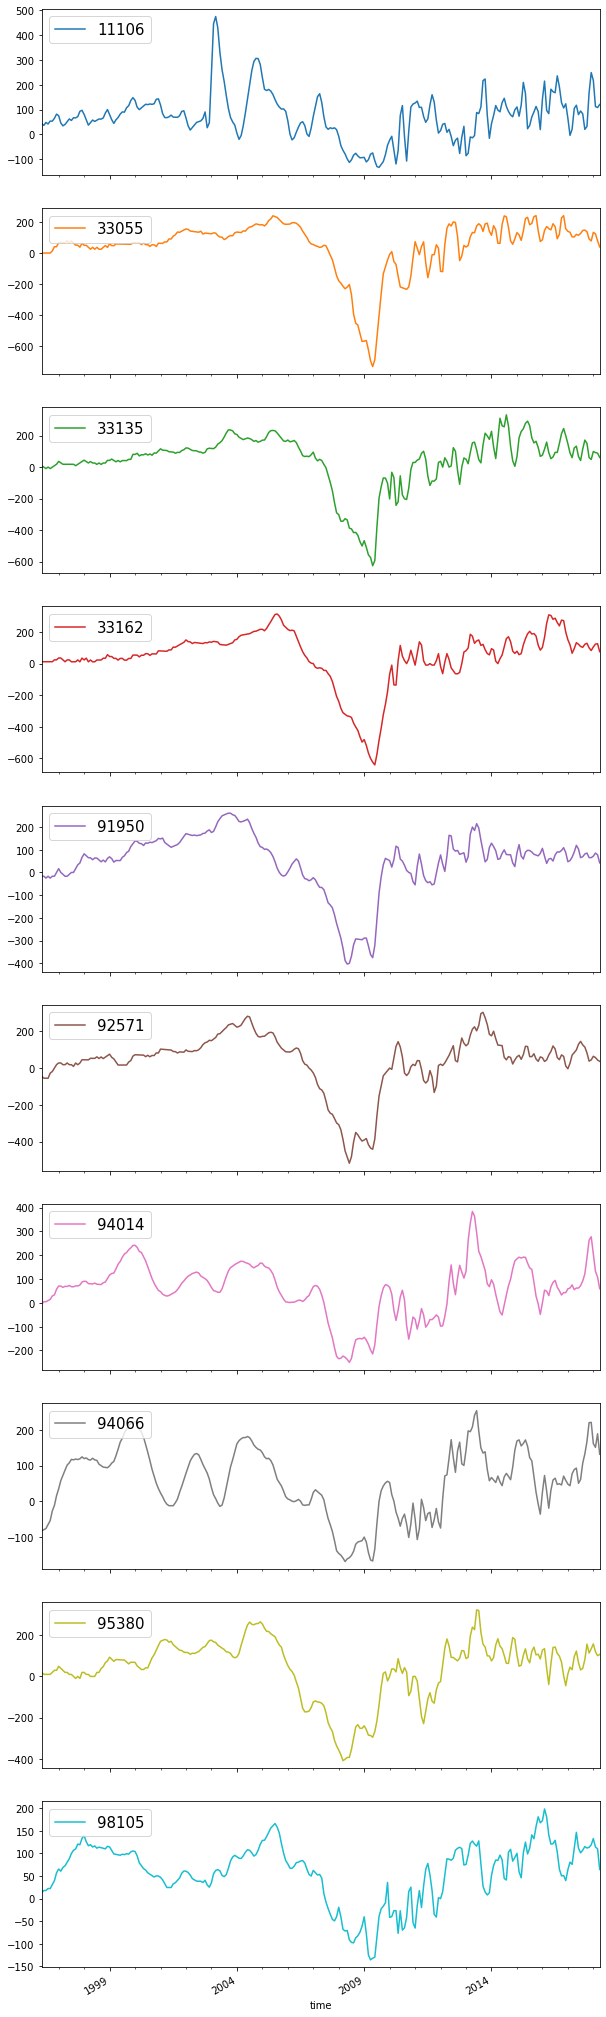

In [61]:
plot_moving_average(vd_top10)

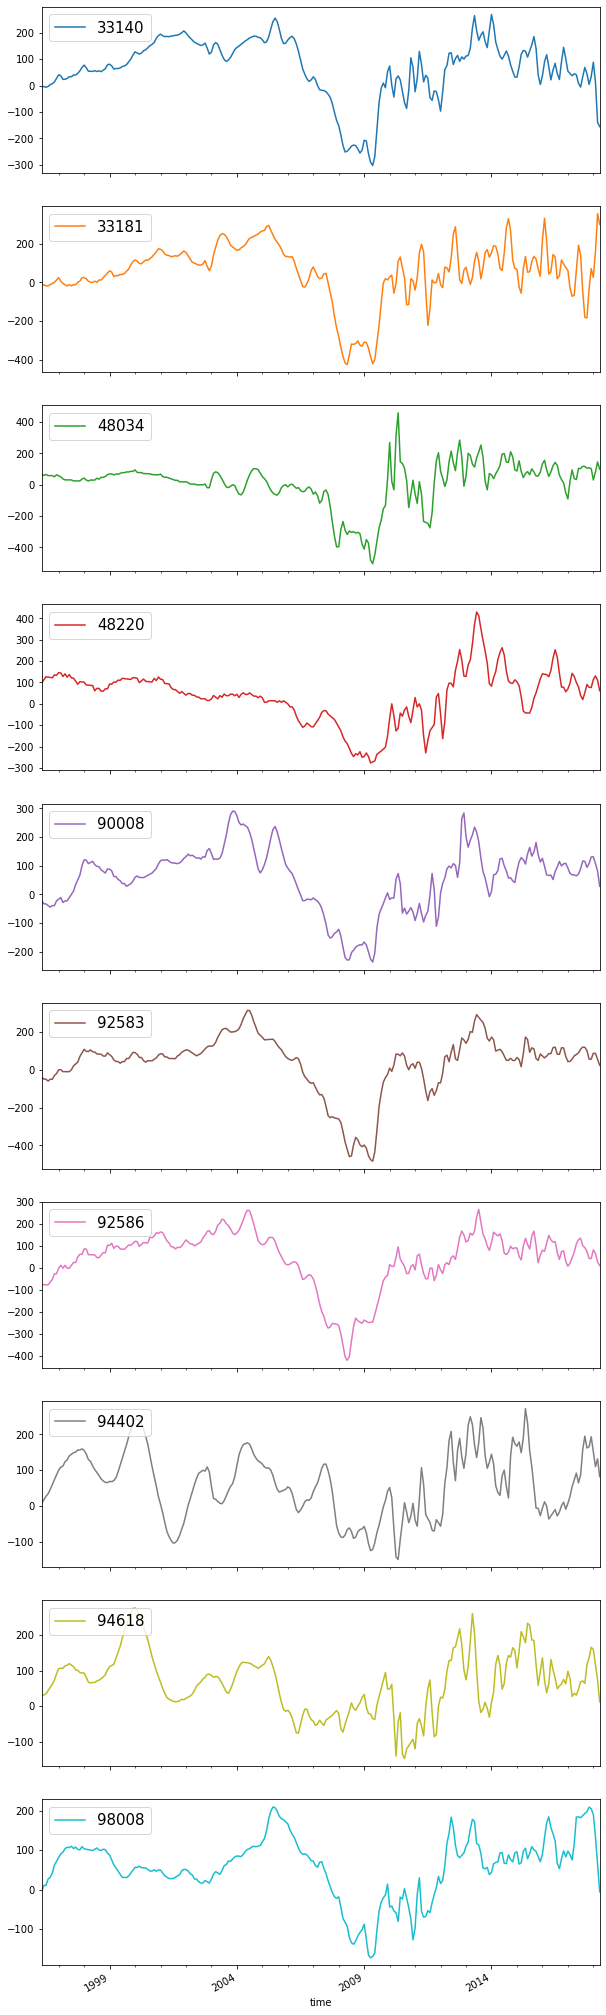

In [62]:
plot_moving_average(dense_top10)

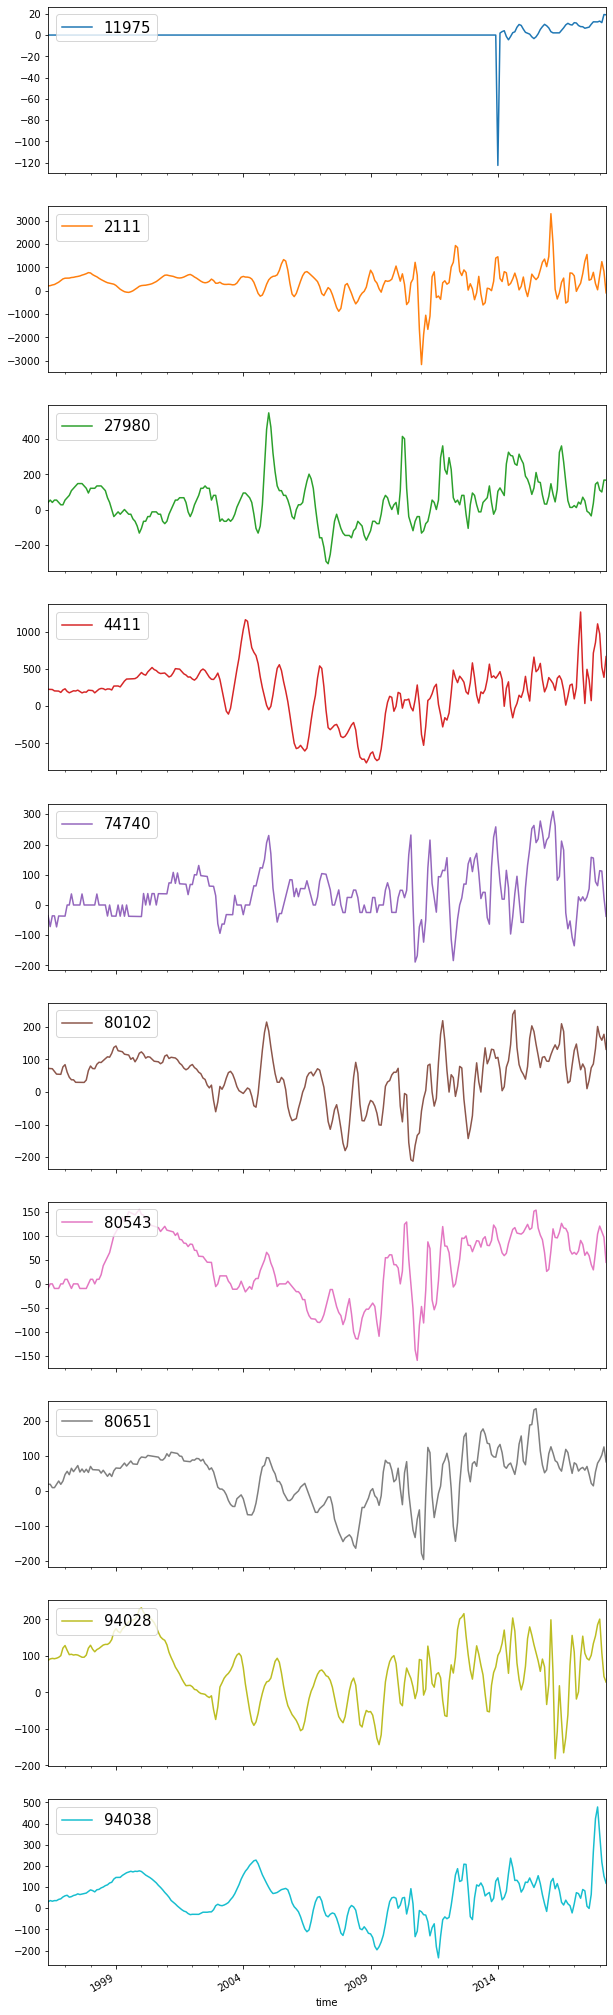

In [63]:
plot_moving_average(nd_top10)

It's tough to eyeball, and the plots do look a bit better, but there are still some hints of trend and seasonality in many of the zipcodes. Many of the not-dense zipcodes (ex. 00441), and medium-dense zipcodes (ex. 98008) still display an upward trend, especially after 2009 . Furthermore, seasonality is evident as some of the spikes in return on investment seem to occur at regular intervals. 

Before moving on, I will apply `seasonal_decompose` and log-transform the series to see if that has an effect on getting rid of some of the remaining trend and seasonality.

## Decomposing Data and Making Data Stationary
#### Not Dense Dataset

In [94]:
#Create function to quickly transform and log all 3 datasets
def drop_and_log (df): 
    df = df.drop(['zipcode','population','City','State','Metro','CountyName','SizeRank','avg_roi','value','difference'], axis=1)
    ts = np.log(df)
    ts[ts == -np.inf] = 1
    ts = nd_ts.fillna(0)
    return ts
                  

In [97]:
nd_ts = drop_and_log(nd_top10)

<ipython-input-94-2110a57f5557>:3: RuntimeWarning: divide by zero encountered in log
  ts = np.log(df)
<ipython-input-94-2110a57f5557>:3: RuntimeWarning: invalid value encountered in log
  ts = np.log(df)


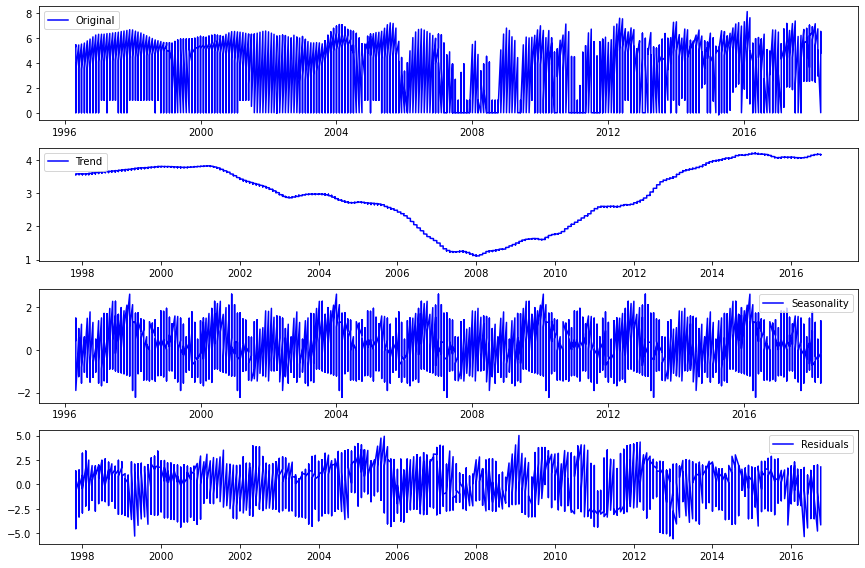

In [92]:
#Apply seasonal_decompose (log-transform series)
decomposition = seasonal_decompose(nd_ts, model='additive',period=365)
#Gather the trend, seasonality,  and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
#Plot gathered statistics 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(nd_ts, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

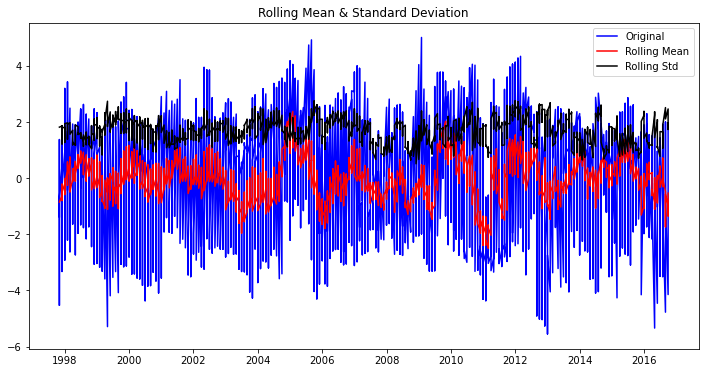

Results of Dickey-Fuller Test: 

Test Statistic                -5.812811e+00
p-value                        4.361374e-07
#Lags Used                     2.100000e+01
Number of Observations Used    2.254000e+03
Critical Value (1%)           -3.433255e+00
Critical Value (5%)           -2.862823e+00
Critical Value (10%)          -2.567453e+00
dtype: float64


In [91]:
# Drop missing values from residuals 
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(ts_log_decompose)

With the "rural" (not densely populated) dataset, the test statistic is negative (and less than 0.01); therefore I can reject the null hypothesis that there is some trend in the data.

#### Dense Dataset 

In [98]:
d_ts = drop_and_log(dense_top10)

<ipython-input-94-2110a57f5557>:3: RuntimeWarning: divide by zero encountered in log
  ts = np.log(df)
<ipython-input-94-2110a57f5557>:3: RuntimeWarning: invalid value encountered in log
  ts = np.log(df)


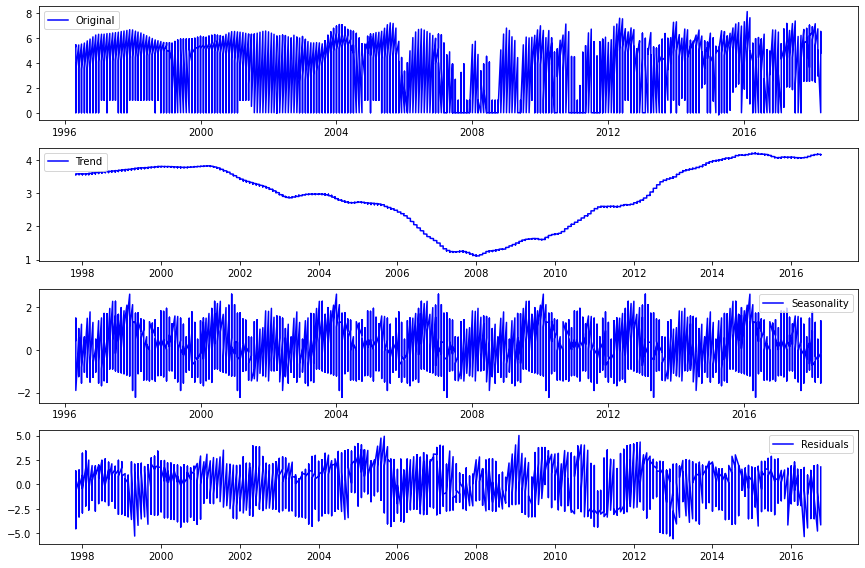

In [106]:
#Apply seasonal_decompose (log-transform series)
dense_decomposition = seasonal_decompose(d_ts, model='additive',period=365)
#Gather the trend, seasonality,  and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
dense_residual = decomposition.resid
#Plot gathered statistics 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(d_ts, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

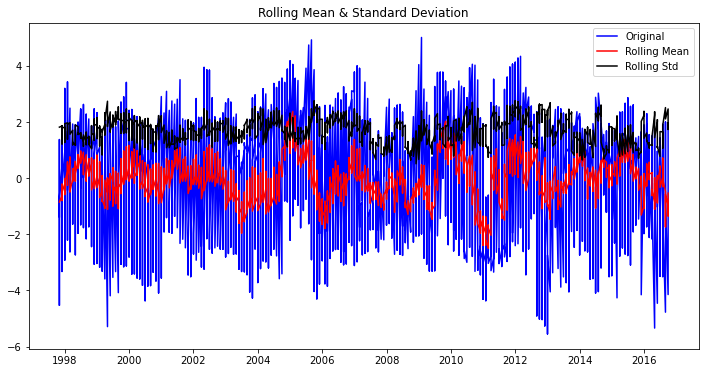

Results of Dickey-Fuller Test: 

Test Statistic                -5.812811e+00
p-value                        4.361374e-07
#Lags Used                     2.100000e+01
Number of Observations Used    2.254000e+03
Critical Value (1%)           -3.433255e+00
Critical Value (5%)           -2.862823e+00
Critical Value (10%)          -2.567453e+00
dtype: float64


In [107]:
# Drop missing values from residuals 
dense_log_decompose = dense_residual
dense_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(dense_log_decompose)

Same with the "mid-size" (densely populated) dataset, the test statistic is negative (and less than 0.01); therefore I can reject the null hypothesis that there is some trend in the data.

#### Very Dense Dataset

In [102]:
vd_ts = drop_and_log(vd_top10)

<ipython-input-94-2110a57f5557>:3: RuntimeWarning: divide by zero encountered in log
  ts = np.log(df)
<ipython-input-94-2110a57f5557>:3: RuntimeWarning: invalid value encountered in log
  ts = np.log(df)


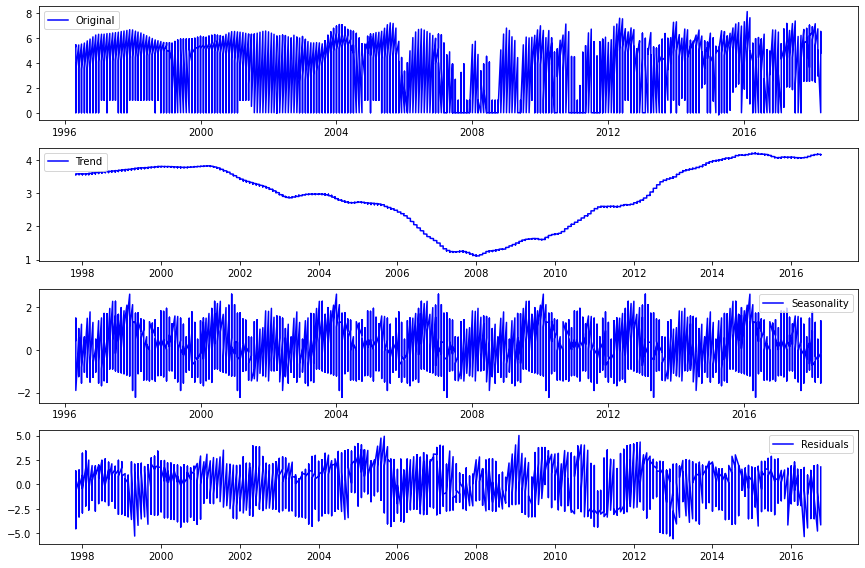

In [109]:
#Apply seasonal_decompose (log-transform series)
decomposition = seasonal_decompose(vd_ts, model='additive',period=365)
#Gather the trend, seasonality,  and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
vdense_residual = decomposition.resid
#Plot gathered statistics 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(vd_ts, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

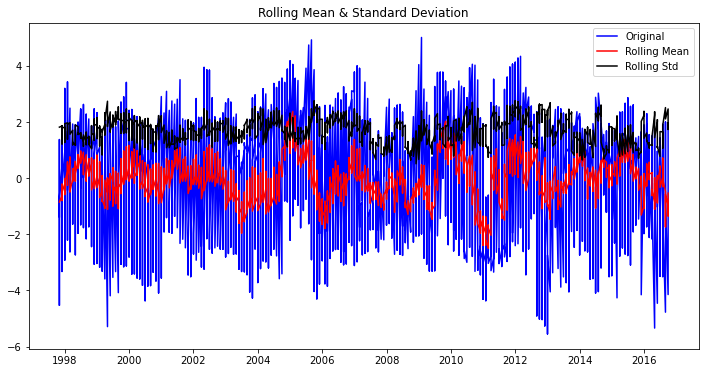

Results of Dickey-Fuller Test: 

Test Statistic                -5.812811e+00
p-value                        4.361374e-07
#Lags Used                     2.100000e+01
Number of Observations Used    2.254000e+03
Critical Value (1%)           -3.433255e+00
Critical Value (5%)           -2.862823e+00
Critical Value (10%)          -2.567453e+00
dtype: float64


In [110]:
# Drop missing values from residuals 
vdense_ts_log_decompose = vdense_residual
vdense_ts_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(vdense_ts_log_decompose)

And same with the urban/densely populated zipcodes; the test statistic is < 0.01, so I can reject the null hypothesis that the data is non-stationary

## Preprocessing 
Since I just want to include real estate values for sales after June 2009 in my model, I will shorten my timeseries dataframes to only this date range from here on out. I'll used the logged timeseries datasets I created in the last step for my actual modeling.

In [115]:
# Rural dataset
nd_ts = nd_ts['2009-06-01':]

In [117]:
# Mid-size dataset 
d_ts = d_ts['2009-06-01':]

In [118]:
# Big city dataset 
vd_ts = vd_ts['2009-06-01':]

#### Train-Test Split

In [121]:
# Find the index which allows us to split off 20% of the data
# Calculate the 80% mark by multiplying the row index of the shape attribute
# Use the built in round function to find the nearest integer 

#Since the timseries are all the same size 
#I should only have to do this once 
end_of_train_index = round(nd_ts.shape[0] * .8)
end_of_train_index

856

In [123]:
# Define train and test sets according to the index found above 
# Rural dataset 
nd_train = nd_ts.iloc[:end_of_train_index]
nd_test = nd_ts.iloc[end_of_train_index:]

In [124]:
# Mid-size dataset 
d_train = d_ts.iloc[:end_of_train_index]
d_test = d_ts.iloc[end_of_train_index:]

In [125]:
# Big city dataset 
vd_train = vd_ts.iloc[:end_of_train_index]
vd_test = vd_ts.iloc[end_of_train_index:]

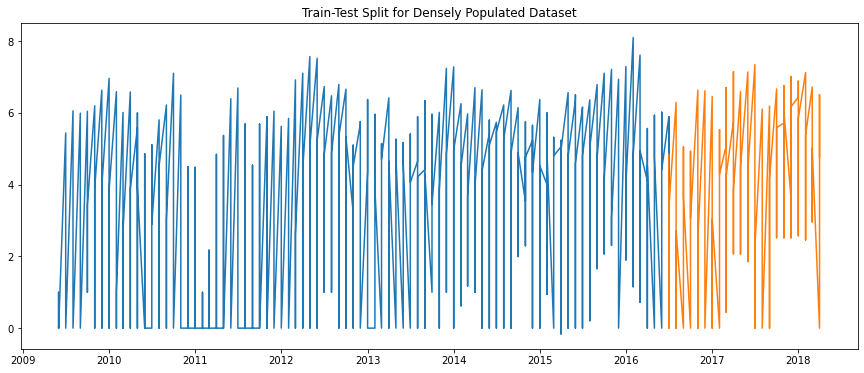

In [128]:
# Looking at big city dataset as an example
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(vd_train)
ax.plot(vd_test)
ax.set_title('Train-Test Split for Densely Populated Dataset');

## Modeling

### Model 1: Random Walk
For the first model I'll try simply predicting the next data point with the point previous to it. 

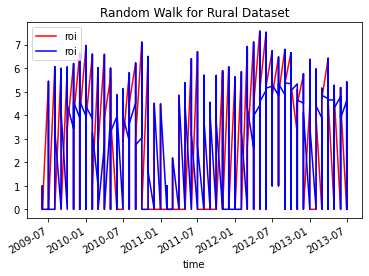

In [151]:
# Rural dataset
nd_random_walk = nd_train.shift(1)

fig, ax1 = plt.subplots()

nd_train[0:500].plot(ax=ax1, c='r', label='original')
nd_random_walk[0:500].plot(ax=ax1, c='b', label='shifted')
ax1.set_title('Random Walk for Rural Dataset')
ax1.legend();

In [152]:
# Calculate RMSE for above dataset 
nd_residuals = nd_random_walk - nd_train
nd_rmse = mean_squared_error(nd_train[1:], nd_random_walk.dropna(),squared=False)
nd_rmse

2.786387266841224

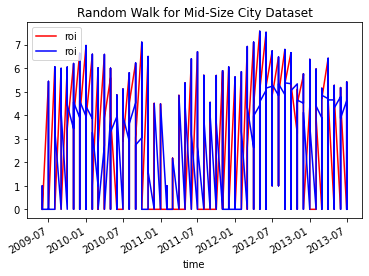

In [145]:
# Mid-size dataset
d_random_walk = d_train.shift(1)

fig, ax = plt.subplots()

d_train[0:500].plot(ax=ax, c='r', label='original')
d_random_walk[0:500].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk for Mid-Size City Dataset')
ax.legend();

In [147]:
# Calculate RMSE for above dataset 
d_residuals = d_random_walk - d_train
d_rmse = mean_squared_error(d_train[1:], d_random_walk.dropna(),squared=False)
d_rmse

2.786387266841224

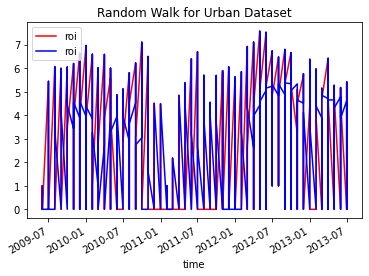

In [153]:
# Random walk for urban dataset
vd_random_walk = vd_train.shift(1)

fig, ax = plt.subplots()

vd_train[0:500].plot(ax=ax, c='r', label='original')
vd_random_walk[0:500].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk for Urban Dataset')
ax.legend();

In [154]:
# Calculate RMSE for above dataset 
vd_residuals = vd_random_walk - vd_train
vd_rmse = mean_squared_error(vd_train[1:], vd_random_walk.dropna(),squared=False)
vd_rmse

2.786387266841224

All three models have the same RMSE - this could be because they are logged?

### Model 2: ARIMA

## Conclusions and Next Steps

- Rental properties vs. residential 
- Update model with 2020 census results, then rerun. 